In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
from mdetsims import Sim, SimOLD

In [5]:
mbobs = Sim(
    rng=np.random.RandomState(seed=3897),
    g1=0.02,
    gal_type='exp',
    psf_type='gauss',
    n_coadd=30).get_mbobs()

mbobs_old = SimOLD(
    rng=np.random.RandomState(seed=3897),
    g1=0.02,
    gal_type='exp',
    psf_type='gauss',
    n_coadd=30).get_mbobs()

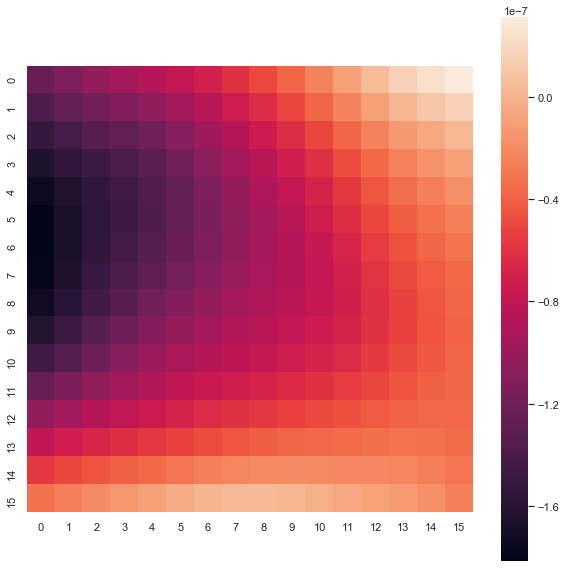

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap((mbobs_old[0][0].image[:16, :16] - mbobs[0][0].image[:16, :16])/np.max(mbobs[0][0].image), square=True)